# Imports

In [1]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne

2025-10-20 14:52:15.911788: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 14:52:15.956824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 14:52:17.583296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 14:52:22.108693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-poin

# U-net Keras Backbone Model (3D)
- Does not facilitate weak supervision yet, we add that later.
- The moving and fixed images are concatenated to be an input to the NN

In [2]:
#model

from tensorflow.keras import layers
from tensorflow import keras

def get_model(moving_image_shape, fixed_image_shape, with_label_inputs=True, up_filters=[64, 128, 256], down_filters=[256, 128, 64, 32]):

    input_moving_image = keras.Input(moving_image_shape)
    input_fixed_image = keras.Input(fixed_image_shape)

    if with_label_inputs:
        input_moving_label = keras.Input(moving_image_shape)
        input_fixed_label = keras.Input(fixed_image_shape)

    concatenate_layer = layers.Concatenate(axis=-1)([input_moving_image, input_fixed_image])

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv3D(32, 3, strides=2, padding="same")(concatenate_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in up_filters:
        x = layers.Activation("relu")(x)
        x = layers.Conv3D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv3D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling3D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv3D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in down_filters:
        x = layers.Activation("relu")(x)
        x = layers.Conv3DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv3DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling3D(2)(x)

        # Project residual
        residual = layers.UpSampling3D(2)(previous_block_activation)
        residual = layers.Conv3D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    out_ddf = layers.Conv3D(3, 3, activation="linear", padding="same")(x)

    # Define the model
    if with_label_inputs:
        model = keras.Model(inputs=[input_moving_image, input_fixed_image, input_moving_label, input_fixed_label], outputs=[out_ddf])
    else:
        model = keras.Model(inputs=[input_moving_image, input_fixed_image], outputs=[out_ddf])
    return model

# View Model Architecture

You have to comment out the with_label_inputs condition at the end, or you get an inputs not connected to outputs error, because the model is not perfect. But it works.


Backbone model inputs and outputs:
    input shape:  (None, 64, 64, 64, 1), (None, 64, 64, 64, 1)
    output shape: (None, 64, 64, 64, 3)

Registration network inputs and outputs:
    input shape:  (None, 64, 64, 64, 1), (None, 64, 64, 64, 1), (None, 64, 64, 64, 1), (None, 64, 64, 64, 1)
    output shape: (None, 64, 64, 64, 1), (None, 64, 64, 64, 3), (None, 64, 64, 64, 1)


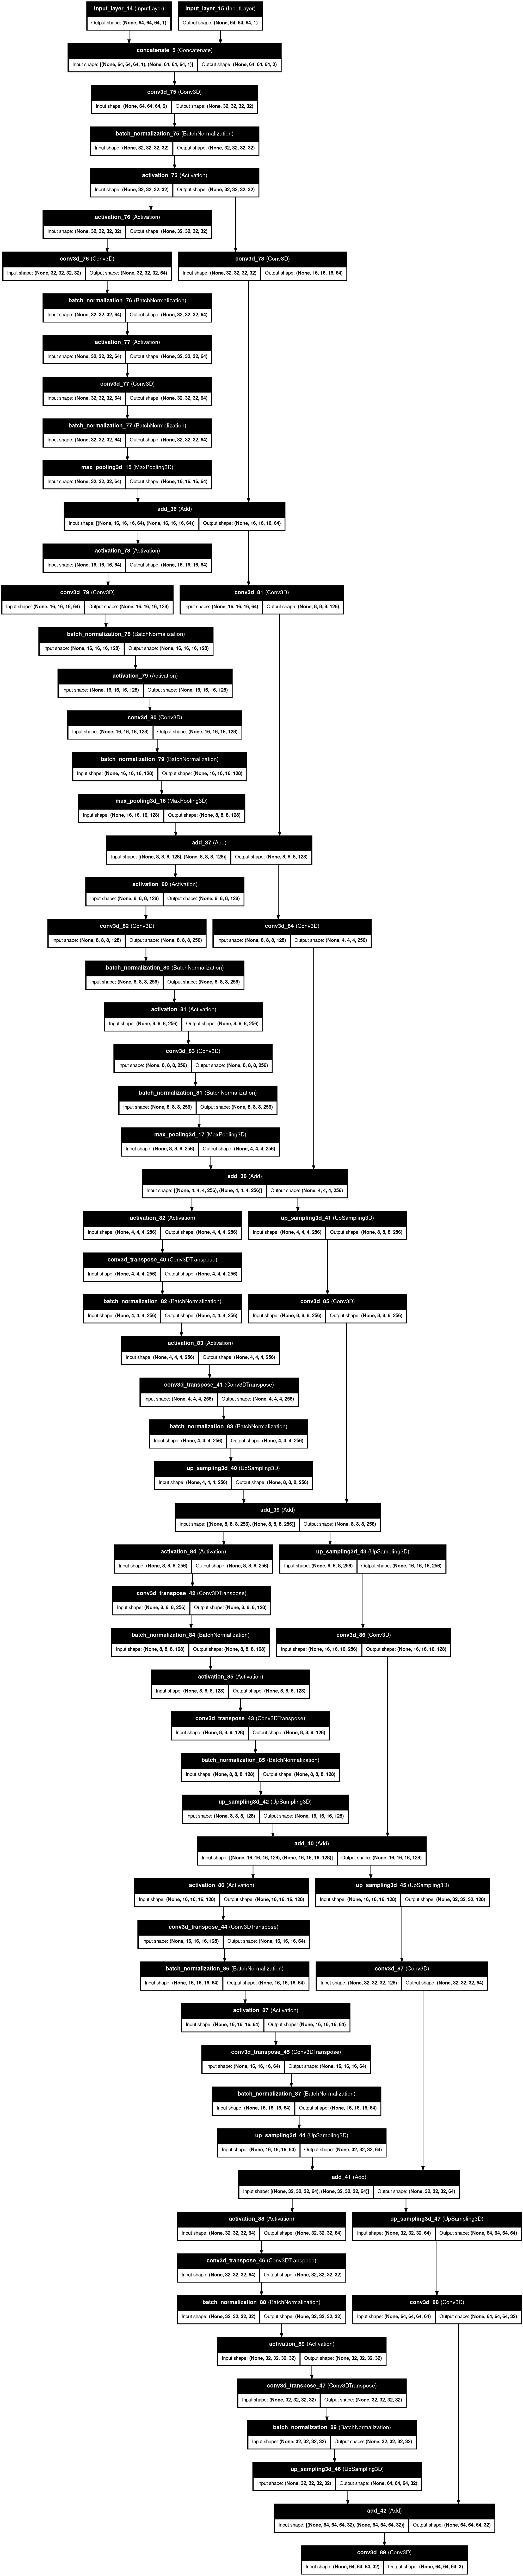

In [8]:
# from tensorflow.keras.utils import plot_model

# model = get_model((64, 64, 64, 1), (64, 64, 64, 1))  # example shapes
# plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, expand_nested=True)
from tensorflow.keras.utils import plot_model

# Assuming your model is already built
moving_image_shape = (64, 64, 64, 1)
fixed_image_shape = (64, 64, 64, 1)
model = get_model((64, 64, 64, 1), (64, 64, 64, 1), with_label_inputs=False)
        
print('\nBackbone model inputs and outputs:')

print('    input shape: ', ', '.join([str(t.shape) for t in model.inputs]))
print('    output shape:', ', '.join([str(t.shape) for t in model.outputs]))

# =============================================================================
# Build the registration network
# =============================================================================

# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the moving image
moving_image = model.input[0]
fixed_image = model.inputs[1]
input_moving_label = keras.Input(moving_image_shape, name="moving_label")
input_fixed_label  = keras.Input(fixed_image_shape,  name="fixed_label")
inputs=[moving_image, fixed_image, input_moving_label, input_fixed_label]

# extract ddf
ddf = model.outputs[0]

# warp the moving image with the transformer using network-predicted ddf
moved_image = spatial_transformer([moving_image, ddf])
moved_label = spatial_transformer([input_moving_label, ddf])
fixed_label = spatial_transformer([input_moving_label, ddf])*0 + input_fixed_label # This is a hacky way of making keras stop complaining about inputs not connected to outputs

outputs = [moved_image, ddf, moved_label]

registration_model = keras.Model(inputs=inputs, outputs=outputs)

print('\nRegistration network inputs and outputs:')

print('    input shape: ', ', '.join([str(t.shape) for t in registration_model.inputs]))
print('    output shape:', ', '.join([str(t.shape) for t in registration_model.outputs]))

losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss, vxm.losses.Dice().loss]

loss_weights = [1, 0.05, 1]

# Save the model architecture diagram to file
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,          # display input/output tensor shapes
    show_layer_names=True,     # display layer names
    expand_nested=True,        # expand nested models if any
    dpi=96,                    # resolution of the image
    rankdir='TB'               # top-to-bottom layout (use 'LR' for left-to-right)
)


# Data Generator (3D, weakly supervised)
- adapted for weak supervision in this instance

In [4]:
#data generator

from skimage.transform import resize
import nibabel as nib

def resize_3d_image(image, shape):
    resized_image = resize(image, output_shape=shape)
    if np.amax(resized_image) == np.amin(resized_image):
        normalised_image = resized_image
    else:
        normalised_image = (resized_image-np.amin(resized_image))/(np.amax(resized_image)-np.amin(resized_image))
    return normalised_image

def train_generator_(f_path, batch_size, moving_image_shape, fixed_image_shape, with_label_inputs=True):
    moving_images_path = os.path.join(f_path, 'us_images')
    fixed_images_path = os.path.join(f_path, 'mr_images')

    if with_label_inputs:
        moving_labels_path = os.path.join(f_path, 'us_labels')
        fixed_labels_path = os.path.join(f_path, 'mr_labels')

    all_names = np.array(os.listdir(fixed_images_path))

    while True:

        batch_names = all_names[np.random.permutation(len(all_names))[:batch_size]]

        moving_images_batch = np.zeros((batch_size, *moving_image_shape))
        fixed_images_batch = np.zeros((batch_size, *fixed_image_shape))

        if with_label_inputs:
            moving_labels_batch = np.zeros((batch_size, *moving_image_shape))
            fixed_labels_batch = np.zeros((batch_size, *fixed_image_shape))

        for i, f_name in enumerate(batch_names):
            moving_image = nib.load(os.path.join(moving_images_path, f_name)).get_fdata()
            fixed_image = nib.load(os.path.join(fixed_images_path, f_name)).get_fdata()

            if with_label_inputs:
                moving_label = nib.load(os.path.join(moving_labels_path, f_name)).get_fdata()
                fixed_label = nib.load(os.path.join(fixed_labels_path, f_name)).get_fdata()
                label_to_select = np.random.randint(6) #pick one label randomly for training

            moving_images_batch[i] = resize_3d_image(moving_image, moving_image_shape)
            fixed_images_batch[i] = resize_3d_image(fixed_image, fixed_image_shape)

            if with_label_inputs:
                moving_labels_batch[i] = resize_3d_image(moving_label[:, :, :, label_to_select], moving_image_shape)
                fixed_labels_batch[i] = resize_3d_image(fixed_label[:, :, :, label_to_select], fixed_image_shape)

        zero_phis = np.zeros([batch_size, *moving_image_shape[:-1], 3])

        if with_label_inputs:
            inputs = (
                tf.convert_to_tensor(moving_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(moving_labels_batch, dtype=tf.float32),
                tf.convert_to_tensor(fixed_labels_batch, dtype=tf.float32)
            )
            outputs = (
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(zero_phis, dtype=tf.float32),
                tf.convert_to_tensor(fixed_labels_batch, dtype=tf.float32)
            )
        else:
            inputs = (
                tf.convert_to_tensor(moving_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32)
            )
            outputs = (
                tf.convert_to_tensor(fixed_images_batch, dtype=tf.float32),
                tf.convert_to_tensor(zero_phis, dtype=tf.float32)
            )

        yield inputs, outputs

def test_generator(f_path, batch_size, moving_image_shape, fixed_image_shape, start_index, end_index, label_num, with_label_inputs=True):
    moving_images_path = os.path.join(f_path, 'us_images')
    fixed_images_path = os.path.join(f_path, 'mr_images')

    if with_label_inputs:
        moving_labels_path = os.path.join(f_path, 'us_labels')
        fixed_labels_path = os.path.join(f_path, 'mr_labels')

    all_names = np.array(os.listdir(fixed_images_path))[start_index: end_index]

    if start_index and end_index is not None:
        n_steps = int(np.floor((end_index - start_index) / batch_size))
    else:
        start_index = 0
        end_index = len(all_names)
        n_steps =int( np.floor((end_index - start_index) / batch_size))

    for step in range(n_steps):

        batch_names = all_names[step*batch_size:(step*batch_size)+batch_size]

        moving_images_batch = np.zeros((batch_size, *moving_image_shape))
        fixed_images_batch = np.zeros((batch_size, *fixed_image_shape))

        if with_label_inputs:
            moving_labels_batch = np.zeros((batch_size, *moving_image_shape))
            fixed_labels_batch = np.zeros((batch_size, *fixed_image_shape))

        for i, f_name in enumerate(batch_names):
            moving_image = nib.load(os.path.join(moving_images_path, f_name)).get_fdata()
            fixed_image = nib.load(os.path.join(fixed_images_path, f_name)).get_fdata()

            if with_label_inputs:
                moving_label = nib.load(os.path.join(moving_labels_path, f_name)).get_fdata() # if label not available, just pass zeros
                fixed_label = nib.load(os.path.join(fixed_labels_path, f_name)).get_fdata() # if label not available, just pass zeros

                label_to_select = label_num #pick one label randomly for training

            moving_images_batch[i] = resize_3d_image(moving_image, moving_image_shape)
            fixed_images_batch[i] = resize_3d_image(fixed_image, fixed_image_shape)

            if with_label_inputs:
                moving_labels_batch[i] = resize_3d_image(moving_label[:, :, :, label_to_select], moving_image_shape)
                fixed_labels_batch[i] = resize_3d_image(fixed_label[:, :, :, label_to_select], fixed_image_shape)

        zero_phis = np.zeros([batch_size, *moving_image_shape[:-1], 3])

        if with_label_inputs:
            inputs = [moving_images_batch, fixed_images_batch, moving_labels_batch, fixed_labels_batch]
            outputs = [fixed_images_batch, zero_phis, fixed_labels_batch]
        else:
            inputs = [moving_images_batch, fixed_images_batch]
            outputs = [fixed_images_batch, zero_phis]

        yield (inputs, outputs)


# Training Loop (3D, weakly supervised, NCC, US-MRI)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt

def train_model(last_trial=None, latest_weights=None, Verbose=False):
    model_save_path = '3D_WS_US-MRI_NCC_Checkpoints'
    if not os.path.exists(model_save_path):
        os.mkdir(model_save_path)
    
    for lambda_param in [0.05]: # incase you want to tune the regularization scalar
        
        # =============================================================================
        # Build the backbone model
        # =============================================================================
        
        # moving_image_shape = (64, 64, 64, 1)
        # fixed_image_shape = (64, 64, 64, 1)
        moving_image_shape = (80, 80, 80, 1)
        fixed_image_shape = (80, 80, 80, 1)
        
        model = get_model(moving_image_shape, fixed_image_shape, with_label_inputs=False)
        
        print('\nBackbone model inputs and outputs:')
        
        print('    input shape: ', ', '.join([str(t.shape) for t in model.inputs]))
        print('    output shape:', ', '.join([str(t.shape) for t in model.outputs]))
        
        # =============================================================================
        # Build the registration network
        # =============================================================================
        
        # build transformer layer
        spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
        
        # extract the moving image
        moving_image = model.input[0]
        fixed_image = model.inputs[1]
        input_moving_label = keras.Input(moving_image_shape, name="moving_label")
        input_fixed_label  = keras.Input(fixed_image_shape,  name="fixed_label")
        inputs=[moving_image, fixed_image, input_moving_label, input_fixed_label]
        
        # extract ddf
        ddf = model.outputs[0]
        
        # warp the moving image with the transformer using network-predicted ddf
        moved_image = spatial_transformer([moving_image, ddf])
        moved_label = spatial_transformer([input_moving_label, ddf])
        fixed_label = spatial_transformer([input_moving_label, ddf])*0 + input_fixed_label # This is a hacky way of making keras stop complaining about inputs not connected to outputs
        
        outputs = [moved_image, ddf, moved_label]
        
        registration_model = keras.Model(inputs=inputs, outputs=outputs)
        
        print('\nRegistration network inputs and outputs:')
        
        print('    input shape: ', ', '.join([str(t.shape) for t in registration_model.inputs]))
        print('    output shape:', ', '.join([str(t.shape) for t in registration_model.outputs]))
        
        losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss, vxm.losses.Dice().loss]
    
        loss_weights = [1, lambda_param, 1]
        
        registration_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

        # =========================================================================
        # Resume from last trial
        # =========================================================================

        if latest_weights is not None:
            print(f"Resuming from {latest_weights} (trial {last_trial})")
            registration_model.load_weights(latest_weights)
            start_trial = last_trial + 1

            # Load arrays
            val_dice = np.load(os.path.join(model_save_path, "val_dice.npy")).tolist()
            transformer_losses = np.load(os.path.join(model_save_path, "transformer_losses.npy")).tolist()
            losses = np.load(os.path.join(model_save_path, "losses.npy")).tolist()
            conv3d_losses = np.load(os.path.join(model_save_path, "conv3d_losses.npy")).tolist()
            
            # Index from 0 to trial_num
            val_dice = val_dice[:last_trial + 1]
            transformer_losses = transformer_losses[:last_trial + 1]
            losses = losses[:last_trial + 1]
            conv3d_losses = conv3d_losses[:last_trial +1]
        
        else:
            print("No previous weights found, starting fresh")
            start_trial = 0
            val_dice = []
            losses = []
            transformer_losses = []
            conv3d_losses = []
        
        # =============================================================================
        # Training loop
        # =============================================================================
        
        f_path = 'nifti_data/train'
        
        val_path = 'nifti_data/val'
        
        batch_size = 32 # Decrease this if you are running out of RAM - set to 4, 8, 16 ect.
        
        train_gen = train_generator_(f_path, batch_size, moving_image_shape, fixed_image_shape, with_label_inputs=True)
        
        num_trials = 1024 # This may be way above what we require
        
        for trial in range(start_trial, num_trials):
            print(f'\nTrial {trial} / {num_trials-1}:')
        
            hist = registration_model.fit(train_gen, epochs=1, steps_per_epoch=32, verbose=1);

            dice_scores = []
            
            for label_num in [0]:#range(6):
                val_gen = test_generator(val_path, 4, moving_image_shape, fixed_image_shape, start_index=None, end_index=None, label_num=label_num, with_label_inputs=True)
                val_count = 0
                while True:
                    try:
                        (val_inputs, val_outputs) = next(val_gen)
                        moving_images_val, fixed_images_val, moving_labels_val, fixed_labels_val = val_inputs
                        fixed_images_val, zero_phis_val, fixed_labels_val = val_outputs
                        _, ddf_val, _ = registration_model.predict((moving_images_val, fixed_images_val, moving_labels_val, fixed_labels_val), verbose=0)
        
                        moved_labels_val = spatial_transformer([moving_labels_val, ddf_val])
                        moved_images_val = spatial_transformer([moving_images_val, ddf_val])
        
                        if label_num == 0 and val_count == 0 and Verbose:
                            # Moving, moved and fixed image slice indices
                            slice_index_moving = 40#32#moving_images_val.shape[0] // 2
                            slice_index_fixed = 40#32#fixed_images_val.shape[0] // 2
                            print("-",moving_images_val.shape)
                            moving_images_val_slice = tf.squeeze(moving_images_val[0])[slice_index_moving,:,:]
                            fixed_images_val_slice = tf.squeeze(fixed_images_val[0])[slice_index_fixed,:,:]
                            moved_images_val_slice = tf.squeeze(moved_images_val[0])[slice_index_moving,:,:]
            
                            # Moving, moved and fixed label slice indices
                            slice_index_moving = 40#32#moving_labels_val.shape[0] // 2
                            slice_index_fixed = 40#32#fixed_labels_val.shape[0] // 2
                            moving_labels_val_slice = tf.squeeze(moving_labels_val[0])[slice_index_moving,:,:]
                            fixed_labels_val_slice = tf.squeeze(fixed_labels_val[0])[slice_index_fixed,:,:]
                            moved_labels_val_slice = tf.squeeze(moved_labels_val[0])[slice_index_moving,:,:]
            
                            # VISUALLY CHECK FIXED, MOVING MOVED IMAGES
                            print("*", tf.squeeze(moved_images_val_slice).shape)
                            print(moving_images_val.shape)
                            plt.subplot(1,3,1)
                            plt.imshow(tf.squeeze(moved_images_val_slice), cmap='gray')
                            plt.title('Moved Image')
            
                            plt.subplot(1,3,2)
                            plt.imshow(tf.squeeze(moving_images_val_slice), cmap='gray')
                            plt.title('Moving Image')
            
                            plt.subplot(1,3,3)
                            plt.imshow(tf.squeeze(fixed_images_val_slice), cmap='gray')
                            plt.title('Fixed Image')
                            plt.show()
            
                            # VISUALLY CHECK LABELS
                            plt.subplot(1,3,1)
                            plt.imshow(tf.squeeze(moved_labels_val_slice), cmap='gray')
                            plt.title('Moved Label')
                            plt.subplot(1,3,2)
                            plt.imshow(tf.squeeze(moving_labels_val_slice), cmap='gray')
                            plt.title('Moving Label')
                            plt.subplot(1,3,3)
                            plt.imshow(tf.squeeze(fixed_labels_val_slice), cmap='gray')
                            plt.title('Fixed Label')
                            plt.show()
        
                            ddf = ddf_val[1].squeeze()  # Remove batch/channel dims -> (64, 64, 64, 3)
                            mid_z = ddf.shape[0] // 2
                            mid_plane = ddf[mid_z, :, :, :]  # Take middle z-slice -> (64, 64, 3)
                            
                            # Downsample for cleaner visualization
                            flow = mid_plane[::1, ::1]  # Downsample to (21, 21, 3) if you want. I don't downsample at all
                            
                            # Visualize (showing x,y components only - drop z-component for 2D plot)
                            #flow = np.stack([-flow[0][..., 1], -flow[0][..., 0]], axis=-1)
                            ne.plot.flow([flow[..., :2]], width=5);  # Only show x,y vectors
    
                            val_count += 1
                        
                        dice_score = np.array(-1.0 * vxm.losses.Dice().loss(tf.convert_to_tensor(moved_labels_val, dtype='float32'), tf.convert_to_tensor(fixed_labels_val, dtype='float32')))
                        dice_scores.append(dice_score)
                        print("dice scores: ", dice_scores)
                        print('.', end='')
                    except (IndexError, StopIteration) as e:
                        break
    
            losses.append(hist.history["loss"][0])
            transformer_losses.append(hist.history["transformer_loss"][0])
            conv_loss_key = next(
                (key for key in hist.history.keys() 
                 if key.startswith('conv3d_') and key.endswith('_loss')),
                None
            )                
            conv3d_losses.append(hist.history[conv_loss_key][0]) 
            val_dice.append(np.mean(dice_scores))
    
            if Verbose:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.subplots_adjust(wspace=0.5) 
                
                plt.plot(losses, label="Loss")
                plt.plot(transformer_losses, label="Transformer Loss")
                plt.xlabel('Trials')
                plt.ylabel('Losses')
                plt.legend()  
        
                plt.subplot(1, 3, 2)
                plt.plot(conv3d_losses, label="Conv3D Loss")
                plt.xlabel('Trials')
                plt.ylabel('Losses')
                plt.legend()  
                                     
                plt.subplot(1, 3, 3)
                plt.plot(val_dice, 'r')
                plt.xlabel('Trials')
                plt.ylabel('Dice')
                plt.savefig(r'voxelmorph_val_dice_1.png')
                plt.show()
            
            print('    Validation Dice: ', np.mean(dice_scores))

            np.save(os.path.join(model_save_path, "losses.npy"), np.array(losses))
            np.save(os.path.join(model_save_path, "transformer_losses.npy"), np.array(transformer_losses))
            np.save(os.path.join(model_save_path, "conv3d_losses.npy"), np.array(conv3d_losses))
            np.save(os.path.join(model_save_path, "val_dice.npy"), np.array(val_dice))
            print("Training history saved.")
        
            if trial % 8 == 0:
                  save_path = os.path.join(model_save_path, f"weights_trial_{trial}.weights.h5")
                  registration_model.save_weights(save_path)
                  print(f"Weights saved to {save_path}")

In [ ]:
train_model(0,'3D_WS_US-MRI_NCC_Checkpoints/weights_trial_0.weights.h5',Verbose=True)

2025-09-12 09:22:54.216635: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Backbone model inputs and outputs:
    input shape:  (None, 80, 80, 80, 1), (None, 80, 80, 80, 1)
    output shape: (None, 80, 80, 80, 3)

Registration network inputs and outputs:
    input shape:  (None, 80, 80, 80, 1), (None, 80, 80, 80, 1), (None, 80, 80, 80, 1), (None, 80, 80, 80, 1)
    output shape: (None, 80, 80, 80, 1), (None, 80, 80, 80, 3), (None, 80, 80, 80, 1)
Resuming from 3D_WS_US-MRI_NCC_Checkpoints/weights_trial_0.weights.h5 (trial 0)


/home/cmpsha009/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 154 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Trial 1 / 1023:


2025-09-12 09:23:46.726044: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Backbone model inputs and outputs:
    input shape:  (None, 80, 80, 80, 1), (None, 80, 80, 80, 1)
    output shape: (None, 80, 80, 80, 3)

Registration network inputs and outputs:
    input shape:  (None, 80, 80, 80, 1), (None, 80, 80, 80, 1), (None, 80, 80, 80, 1), (None, 80, 80, 80, 1)
    output shape: (None, 80, 80, 80, 1), (None, 80, 80, 80, 3), (None, 80, 80, 80, 1)
Resuming from 3D_WS_US-MRI_NCC_Checkpoints/weights_trial_16.weights.h5 (trial 16)

Trial 17 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 453s 14s/step - conv3d_74_loss: 0.1864 - loss: -0.4276 - transformer_loss: -0.2103


E0000 00:00:1757613444.955178 3457778 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'functional_9_1/up_sampling3d_35_1/Repeat/ExpandDims' exist for missing node 'functional_9_1/add_35_1/Add'.


- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


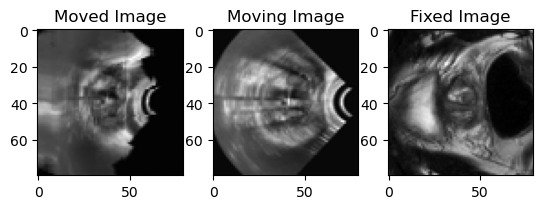

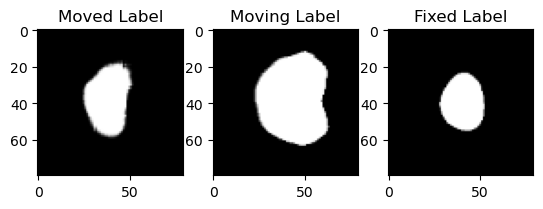

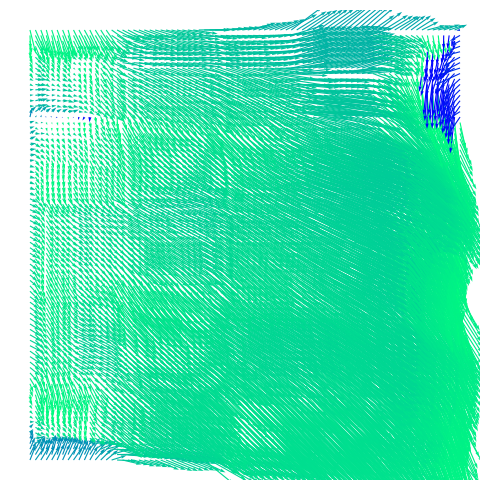

dice scores:  [array(0.5125233, dtype=float32)]
.dice scores:  [array(0.5125233, dtype=float32), array(0.6121509, dtype=float32)]
.

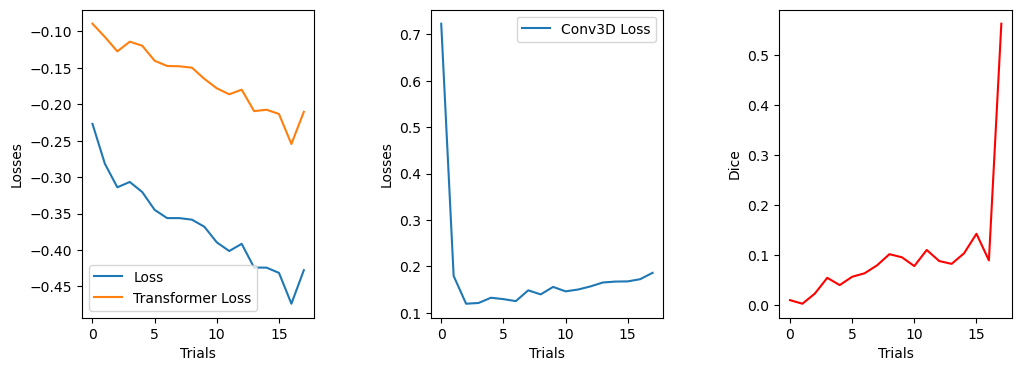

    Validation Dice:  0.5623371
Training history saved.

Trial 18 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 442s 14s/step - conv3d_74_loss: 0.1784 - loss: -0.4885 - transformer_loss: -0.2679
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


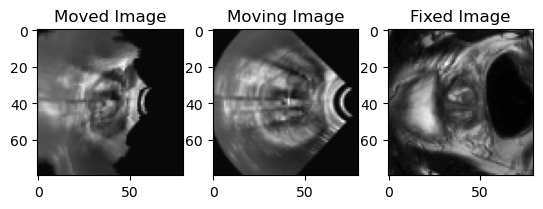

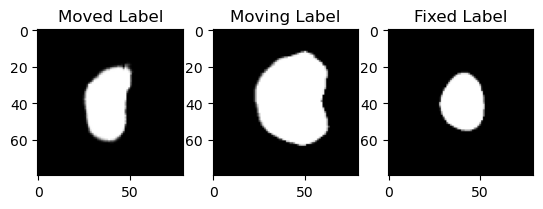

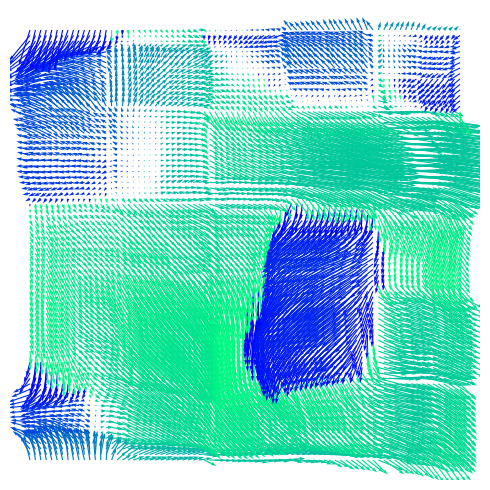

dice scores:  [array(0.5039934, dtype=float32)]
.dice scores:  [array(0.5039934, dtype=float32), array(0.6381807, dtype=float32)]
.

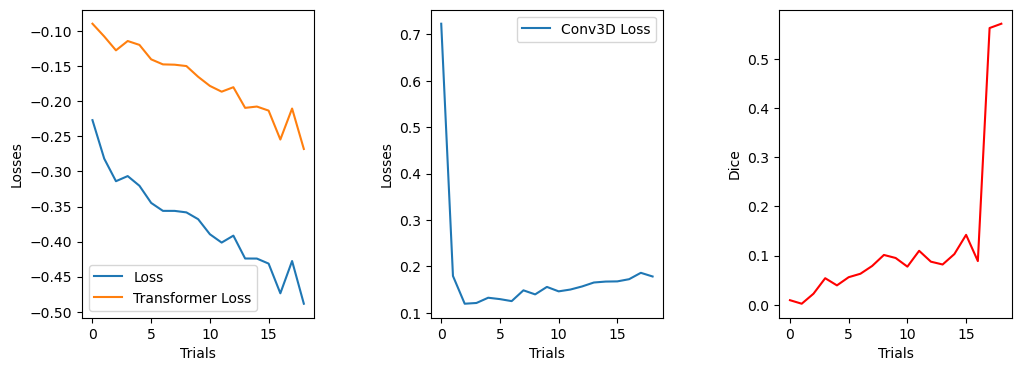

    Validation Dice:  0.571087
Training history saved.

Trial 19 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 441s 14s/step - conv3d_74_loss: 0.1711 - loss: -0.4921 - transformer_loss: -0.2678
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


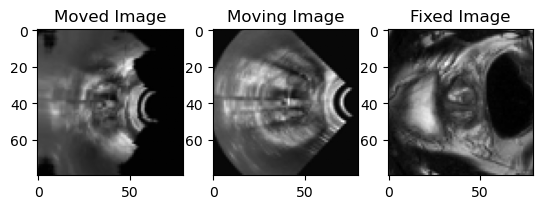

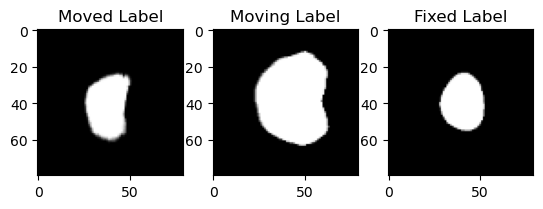

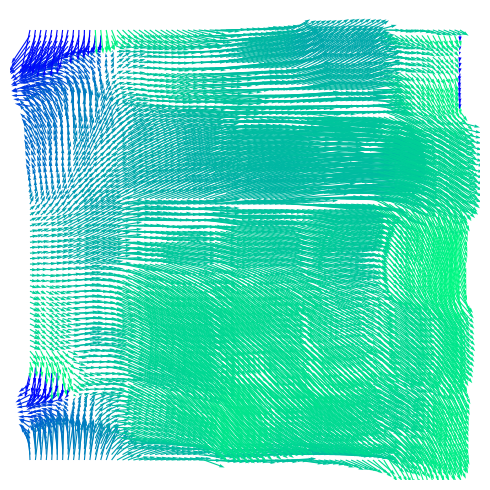

dice scores:  [array(0.54701626, dtype=float32)]
.dice scores:  [array(0.54701626, dtype=float32), array(0.59539145, dtype=float32)]
.

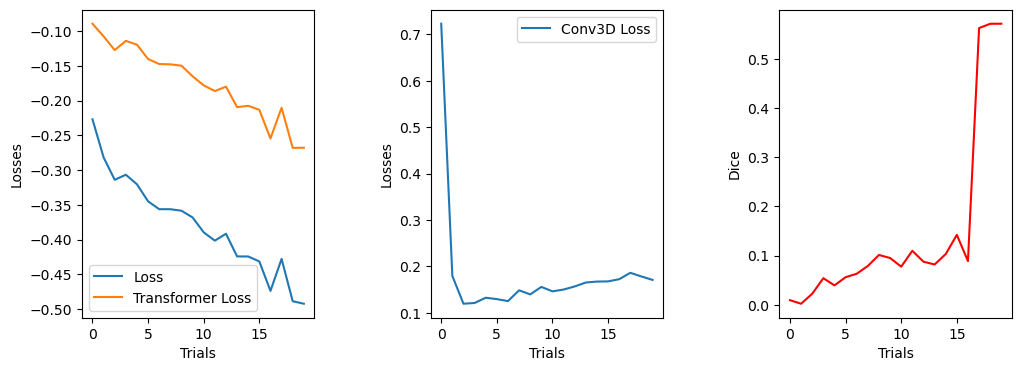

    Validation Dice:  0.5712038
Training history saved.

Trial 20 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 440s 14s/step - conv3d_74_loss: 0.1738 - loss: -0.4888 - transformer_loss: -0.2633
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


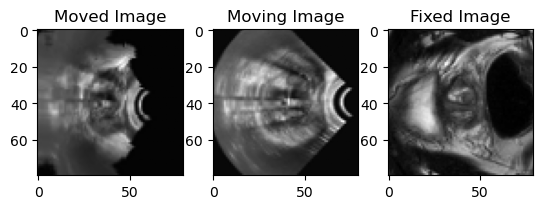

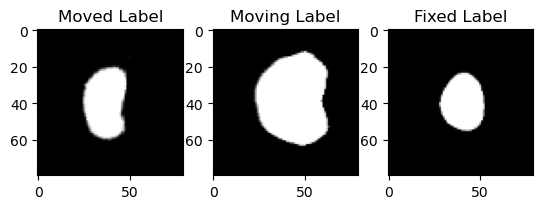

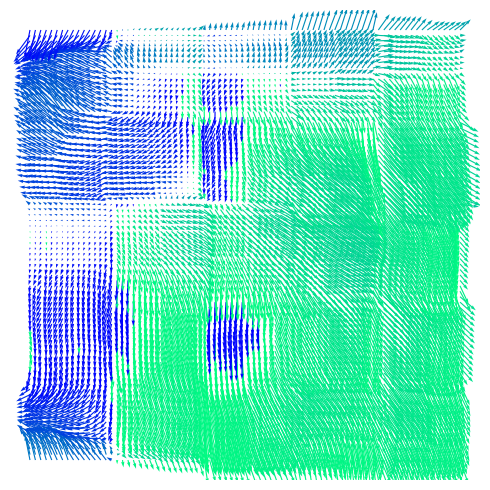

dice scores:  [array(0.55271274, dtype=float32)]
.dice scores:  [array(0.55271274, dtype=float32), array(0.6544194, dtype=float32)]
.

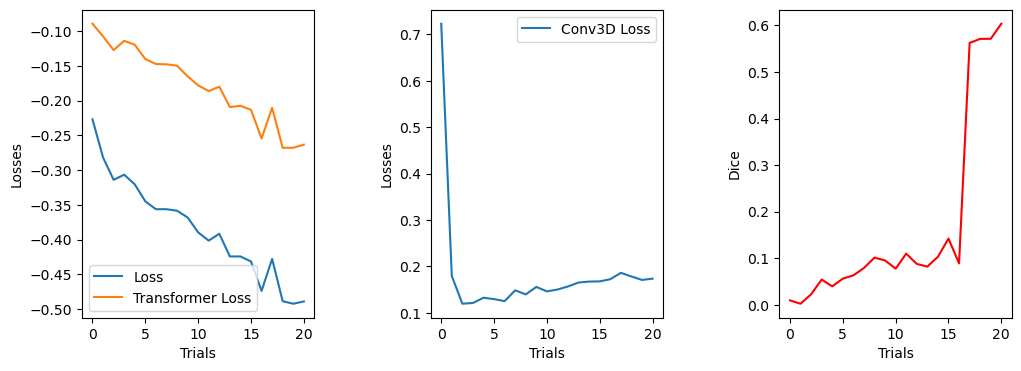

    Validation Dice:  0.60356605
Training history saved.

Trial 21 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 441s 14s/step - conv3d_74_loss: 0.1702 - loss: -0.5240 - transformer_loss: -0.2978
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


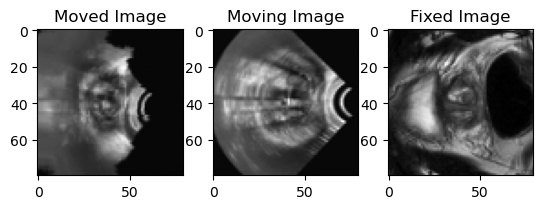

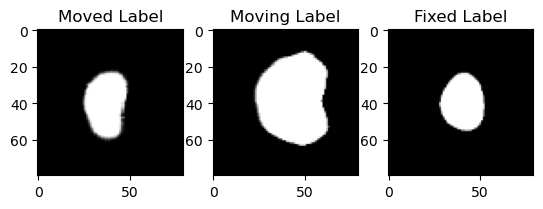

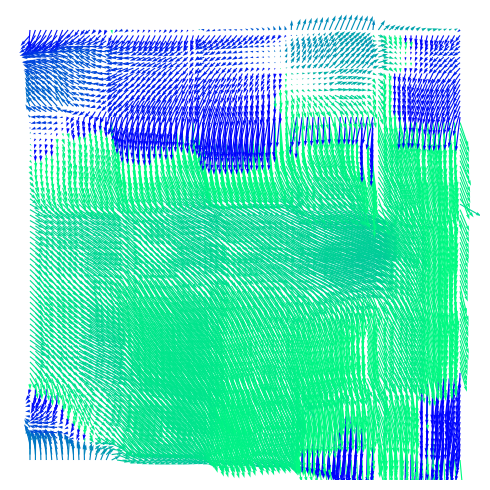

dice scores:  [array(0.53665775, dtype=float32)]
.dice scores:  [array(0.53665775, dtype=float32), array(0.63900185, dtype=float32)]
.

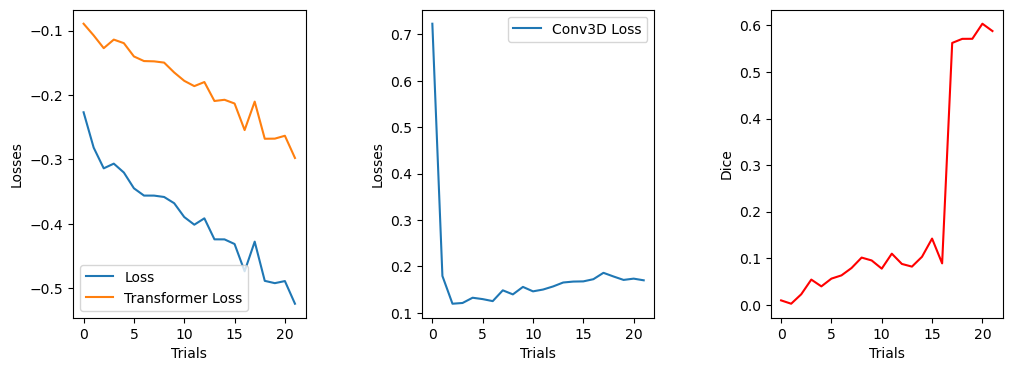

    Validation Dice:  0.5878298
Training history saved.

Trial 22 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 443s 14s/step - conv3d_74_loss: 0.1841 - loss: -0.4900 - transformer_loss: -0.2619
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


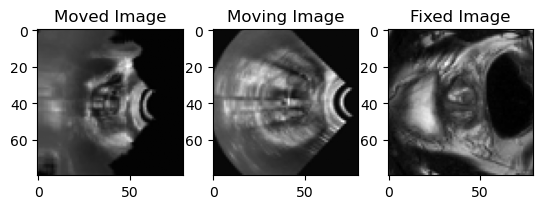

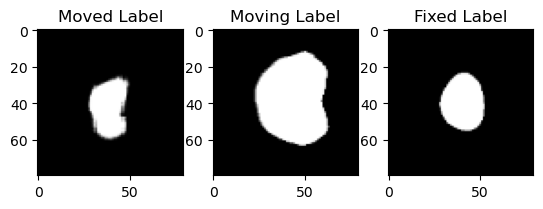

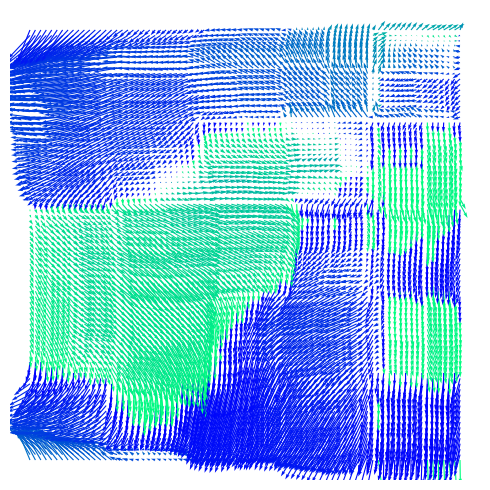

dice scores:  [array(0.5399163, dtype=float32)]
.dice scores:  [array(0.5399163, dtype=float32), array(0.6260433, dtype=float32)]
.

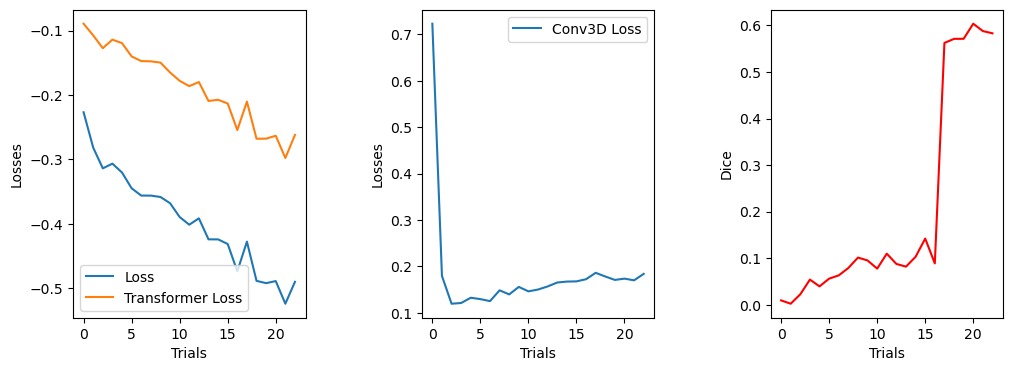

    Validation Dice:  0.5829798
Training history saved.

Trial 23 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 440s 14s/step - conv3d_74_loss: 0.1829 - loss: -0.5309 - transformer_loss: -0.3023
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


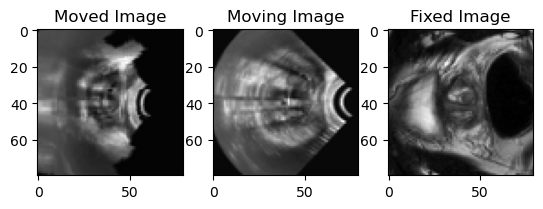

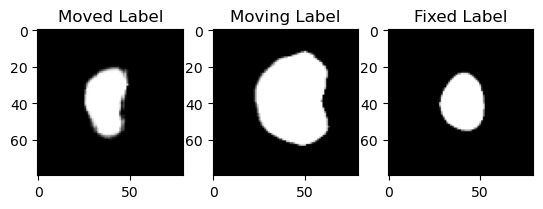

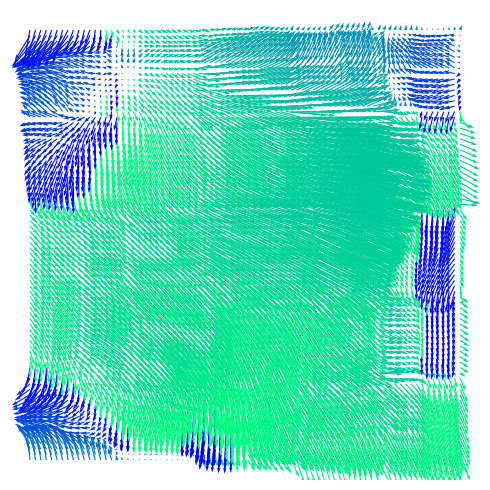

dice scores:  [array(0.47159457, dtype=float32)]
.dice scores:  [array(0.47159457, dtype=float32), array(0.6188482, dtype=float32)]
.

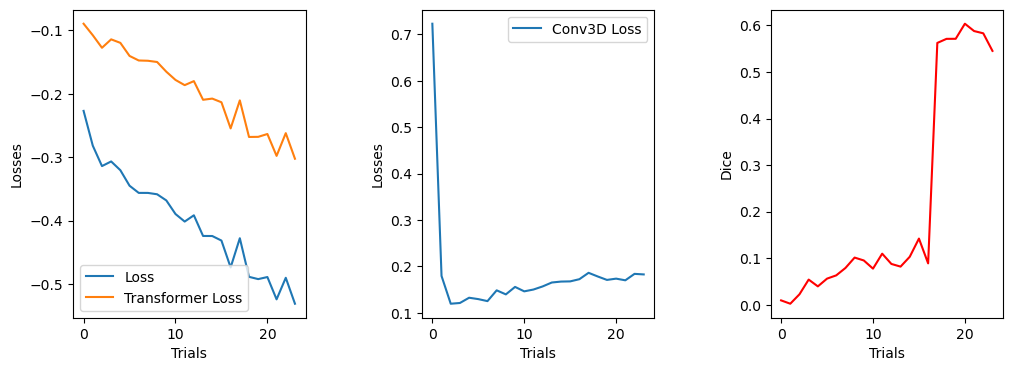

    Validation Dice:  0.5452214
Training history saved.

Trial 24 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 441s 14s/step - conv3d_74_loss: 0.1838 - loss: -0.5232 - transformer_loss: -0.2910
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


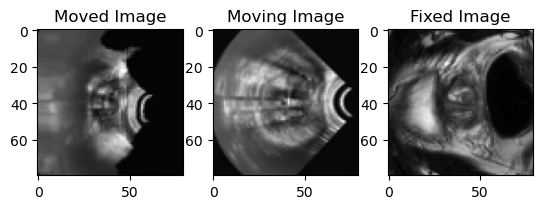

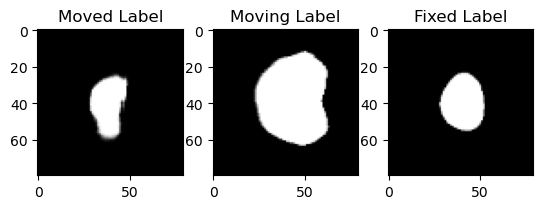

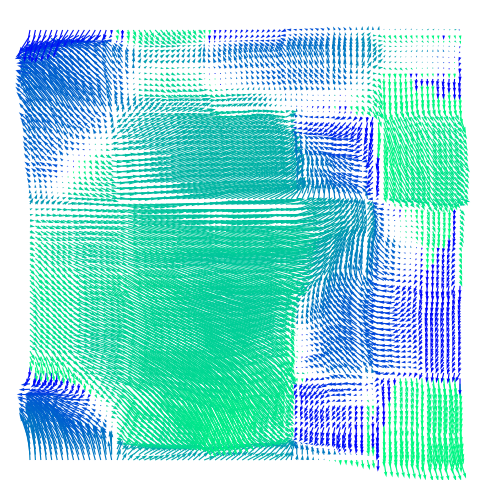

dice scores:  [array(0.61360395, dtype=float32)]
.dice scores:  [array(0.61360395, dtype=float32), array(0.63432276, dtype=float32)]
.

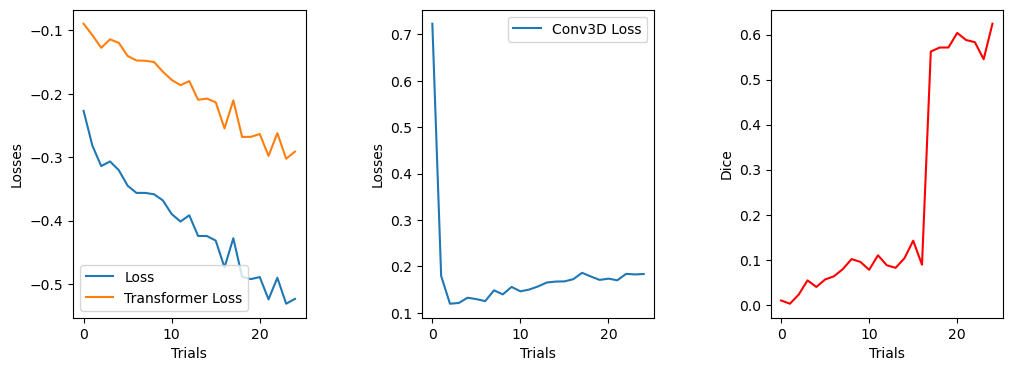

    Validation Dice:  0.62396336
Training history saved.
Weights saved to 3D_WS_US-MRI_NCC_Checkpoints/weights_trial_24.weights.h5

Trial 25 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 442s 14s/step - conv3d_74_loss: 0.1856 - loss: -0.5546 - transformer_loss: -0.3197
- (4, 80, 80, 80, 1)
* (80, 80)
(4, 80, 80, 80, 1)


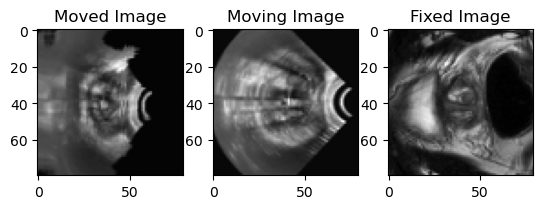

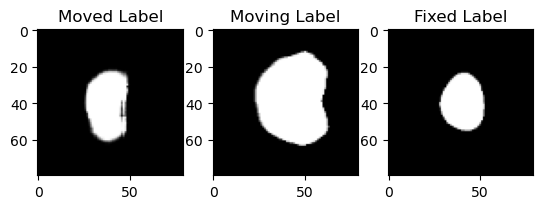

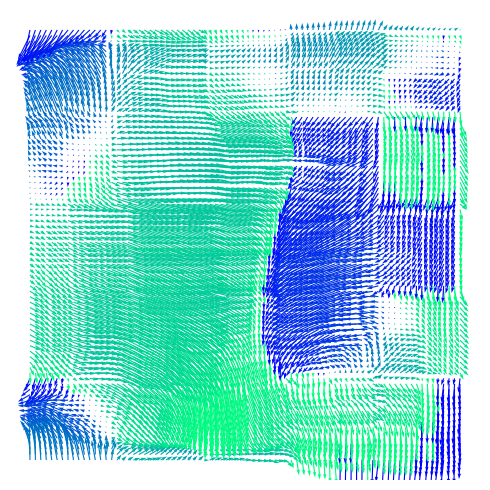

dice scores:  [array(0.5925527, dtype=float32)]
.dice scores:  [array(0.5925527, dtype=float32), array(0.6312523, dtype=float32)]
.

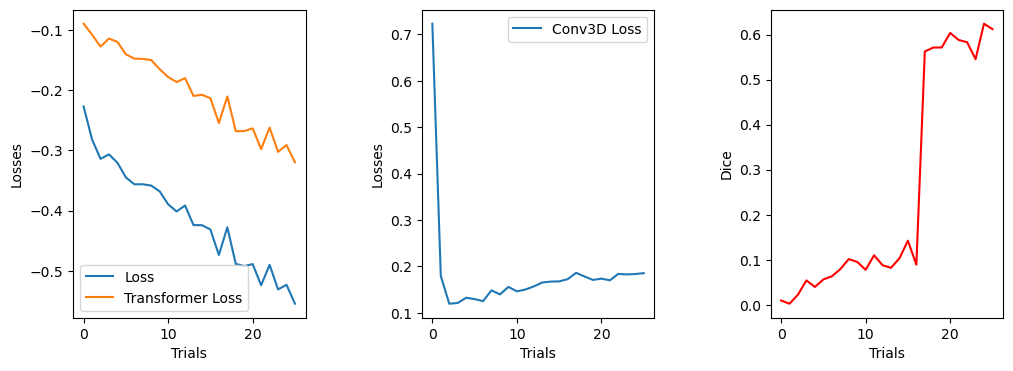

    Validation Dice:  0.6119025
Training history saved.

Trial 26 / 1023:
 2/32 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - conv3d_74_loss: 0.1827 - loss: -0.5832 - transformer_loss: -0.3458

KeyboardInterrupt: 

In [13]:
train_model(16,'3D_WS_US-MRI_NCC_Checkpoints/weights_trial_16.weights.h5',Verbose=True)

In [15]:
train_model(24,'3D_WS_US-MRI_NCC_Checkpoints/weights_trial_24.weights.h5',Verbose=False)


Backbone model inputs and outputs:
    input shape:  (None, 80, 80, 80, 1), (None, 80, 80, 80, 1)
    output shape: (None, 80, 80, 80, 3)

Registration network inputs and outputs:
    input shape:  (None, 80, 80, 80, 1), (None, 80, 80, 80, 1), (None, 80, 80, 80, 1), (None, 80, 80, 80, 1)
    output shape: (None, 80, 80, 80, 1), (None, 80, 80, 80, 3), (None, 80, 80, 80, 1)
Resuming from 3D_WS_US-MRI_NCC_Checkpoints/weights_trial_24.weights.h5 (trial 24)

Trial 25 / 1023:
32/32 ━━━━━━━━━━━━━━━━━━━━ 452s 14s/step - conv3d_104_loss: 0.1892 - loss: -0.5178 - transformer_loss: -0.2896


E0000 00:00:1757617919.351342 3457778 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'functional_13_1/up_sampling3d_55_1/Repeat/ExpandDims' exist for missing node 'functional_13_1/add_53_1/Add'.


dice scores:  [array(0.5643662, dtype=float32)]
.dice scores:  [array(0.5643662, dtype=float32), array(0.6542161, dtype=float32)]
.    Validation Dice:  0.6092912
Training history saved.

Trial 26 / 1023:
28/32 ━━━━━━━━━━━━━━━━━━━━ 56s 14s/step - conv3d_104_loss: 0.1984 - loss: -0.5415 - transformer_loss: -0.3093 

KeyboardInterrupt: 

In [ ]:
train_model(104,'3D_WS_US-MRI_NCC_Checkpoints/weights_trial_104.weights.h5',Verbose=False)

In [4]:
import numpy as np
import os

path = '/scratch/cmpsha009/Output_data_affine'
val_dice = np.load(os.path.join(path, "val_dice.npy")).tolist()
print(val_dice)

[0.7020868062973022]
